Purpose
-------

As a trader interested in cryptocurrencies, this notebook serves as an introductory analysis of price behavior across  several cryptocurrencies

The notebook will demonstrate the following ideas
1. Loading data from the Poloniex API
2. Loading data from Quandl
3. Using pandas to load and serialize data in pickle format
4. Use plotly to visualize price behavior
5. Use pandas to do standard data cleaning and manipulation
6. Use plotly to visualize covariance matrix across altcoins
7. Use pandas functions to do basic summarization of the time series data

## This is our setup. We need these libraries in order to do our analysis

In [116]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
import time
from datetime import datetime
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)


## Quandl is a library that lets us download recent price time-series for lots of different assets

In [ ]:
#This is a helper function to either download our data or load our data

In [37]:
quandl.get('BCHARTS/KRAKENUSD').tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-01-15,13711.1,14438.9,13207.0,13608.3,3531.910480,4.905487e+07,13889.047827
2018-01-16,13606.9,13633.1,10111.0,11533.2,10021.923820,1.181083e+08,11784.994745
2018-01-17,11533.9,11968.9,9225.0,11185.0,11353.589979,1.197142e+08,10544.171307
2018-01-18,11191.0,12262.3,10750.0,11286.0,7722.093004,8.964121e+07,11608.408510
2018-01-19,11286.1,12040.0,11036.4,11330.0,5353.753836,6.194979e+07,11571.281700


In [38]:
def get_quandl_data(quandl_id):
    '''
    Download and cache Quandl dataseries
    
    Checks for recency of >= 1 day and will update data if necessary
    
    '''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
        
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
        
    #check for outdated data
    if datetime.now().day - df.index[-1].day >= 1:
        print('Data is outdated. Updateding from Quandl')
        df = quandl.get(quandl_id, returns='pandas')
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
        
    return df

In [39]:
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache
Data is outdated. Updateding from Quandl
Cached BCHARTS/KRAKENUSD at BCHARTS-KRAKENUSD.pkl


In [141]:
# btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
# py.iplot([btc_trace])

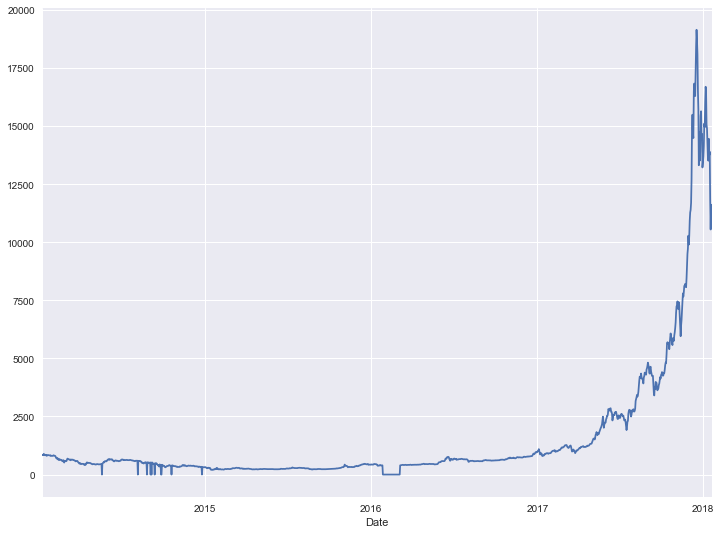

In [144]:
btc_usd_price_kraken['Weighted Price'].plot();

In [8]:
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [9]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [10]:
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')


In [11]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    
    #give us a list of the column headers for the df
    label_arr = list(df)
    #generate a list of each column and its time series
    series_arr = list(map(lambda col: df[col], label_arr))
    
    #plotly needs to know how to display the visualization
    #this looks like it is similar to matplotlib's figure/axes
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
     
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [139]:
#df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange', seperate_y_axis=True)

In [13]:
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [140]:
#df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

### Let's create a new column that takes the mean across each of the exchanges
    axis=1 will take the mean across columns

In [15]:
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

In [137]:
# btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
# py.iplot([btc_trace])

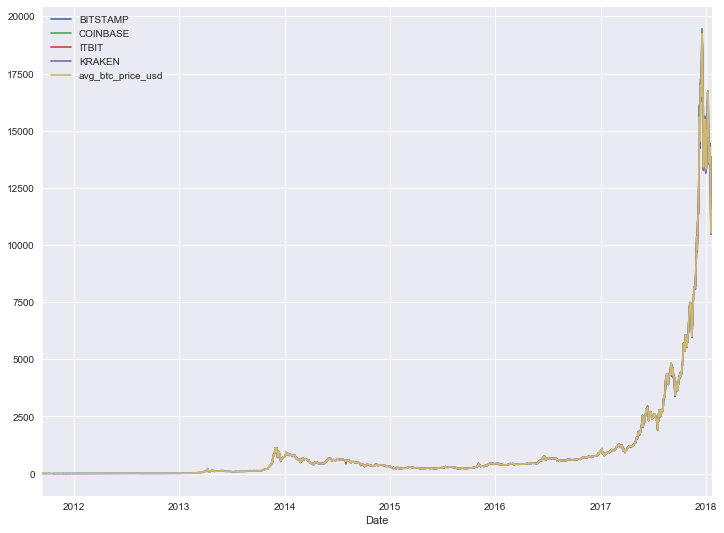

In [146]:
btc_usd_datasets.plot();

## Since we'll be doing API calls the data will be returned as a json file


### Create helper function to load and cache json data

In [74]:
def get_json_data(json_url, cache_path, poloniex_pair):
    '''
    
    Download and cache JSON data, return as a dataframe.
    
    Checks for outdated data >= to one day
    
    '''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
        
        #check for outdated data
    if datetime.now().day - df['date'].iloc[-1].day >= 1:
        print('Data is outdated. Updateing from Poloniex API')
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(poloniex_pair, cache_path))
        
        
    return df

## We need some helper functions for time conversions

In [68]:
def createTimeStamp(datestr, format="%Y-%m-%d %H:%M:%S"):
    return time.mktime(time.strptime(datestr, format))

### Lets set up our API call helpers for poloniex

In [69]:

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'

start_date =createTimeStamp('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = createTimeStamp(datetime.now().strftime('%Y-%m-%d'), '%Y-%m-%d') # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date, end_date, period)
    data_df = get_json_data(json_url, poloniex_pair, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

### Here is our list of altcoins. We'll create comparisons to bitcoin so we can price them later in USD

In [73]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420106400.0&end=1516442400.0&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420106400.0&end=1516442400.0&period=86400 from cache
Data is outdated. Updateding from Poloniex API
Cached BTC_LTC at BTC_LTC
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420106400.0&end=1516442400.0&period=86400 from cache
Data is outdated. Updateding from Poloniex API
Cached BTC_XRP at BTC_XRP
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420106400.0&end=1516442400.0&period=86400 from cache
Data is outdated. Updateding from Poloniex API
Cached BTC_ETC at BTC_ETC
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420106400.0&end=1516442400.0&period=86400 from cache
Data is outdated. Updateding from Poloniex API
Cached BTC_STR at BTC_STR
Loaded h

In [75]:
altcoin_data['DASH'].tail()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2018-01-16,0.066473,0.073145,0.058747,0.068515,24980.120190,1688.351189,0.067588
2018-01-17,0.071288,0.072010,0.064000,0.066473,13109.058027,899.668188,0.068629
2018-01-18,0.073374,0.077000,0.068356,0.071377,14947.071394,1091.680766,0.073036
2018-01-19,0.073470,0.075470,0.071850,0.073741,4641.604543,339.482484,0.073139
2018-01-20,0.072340,0.076130,0.071000,0.073470,5530.408855,404.834759,0.073202


## Compute an average dollar price per altcoin based on the altcoin -> BTC -> USD exchange

In [76]:
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']


In [77]:
#Consolidate all these prices and tokens into the same dataframe
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')


In [78]:
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

In [79]:
combined_df.tail()

,DASH,ETC,ETH,LTC,SC,STR,XEM,XMR,XRP,BTC
date,,,,,,,,,,
2018-01-16,797.490961,32.189765,1077.478792,195.254684,0.038938,0.452504,0.976041,342.966426,1.253915,11799.334773
2018-01-17,722.326880,26.824172,932.170525,170.768875,0.037890,0.392899,0.857894,289.070630,1.103443,10525.020291
2018-01-18,842.938729,30.690517,1043.745343,194.148296,0.048704,0.509781,1.086502,329.123071,1.515033,11541.346268
2018-01-19,842.404376,31.877723,1047.416461,194.341489,0.046532,0.507937,1.064940,340.405334,1.592458,11517.849984
2018-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


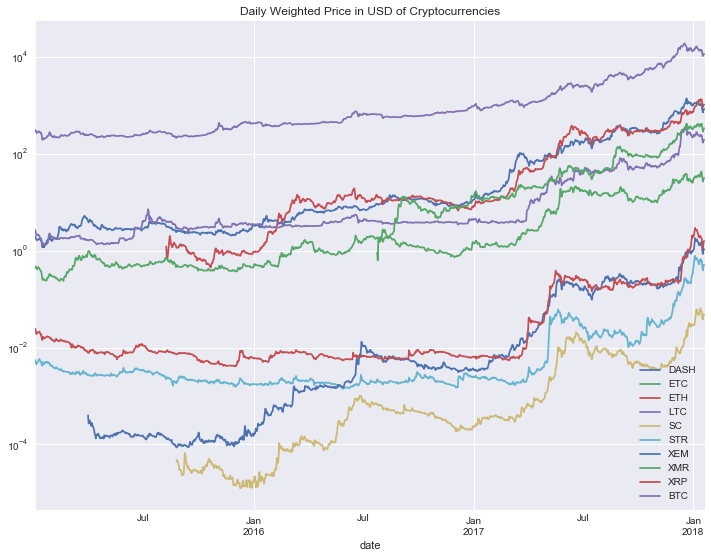

In [133]:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
combined_df.plot(logy=True, title='Daily Weighted Price in USD of Cryptocurrencies');

In [134]:
#df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')


In [ ]:
## Many trading strategies use correlations between assets
#They study the long-term pair-wise behavior and build models of these relationships
#If a pair of assets deviates from its long-term pattern you can buy/sell around the pattern in expectation of reversion

## Pearson Correlation

In [81]:
combined_df_2016 = combined_df[combined_df.index.year == 2016]
combined_df_2016.pct_change().corr(method='pearson')

,DASH,ETC,ETH,LTC,SC,STR,XEM,XMR,XRP,BTC
DASH,1.000000,0.003992,0.122695,-0.012194,0.026602,0.058083,0.014571,0.121537,0.088657,-0.014040
ETC,0.003992,1.000000,-0.181991,-0.131079,-0.008066,-0.102654,-0.080938,-0.105898,-0.054095,-0.170538
ETH,0.122695,-0.181991,1.000000,-0.064652,0.169642,0.035093,0.043205,0.087216,0.085630,-0.006502
LTC,-0.012194,-0.131079,-0.064652,1.000000,0.012253,0.113523,0.160667,0.129475,0.053712,0.750174
SC,0.026602,-0.008066,0.169642,0.012253,1.000000,0.143252,0.106153,0.047910,0.021098,0.035116
STR,0.058083,-0.102654,0.035093,0.113523,0.143252,1.000000,0.225132,0.027998,0.320116,0.079075
XEM,0.014571,-0.080938,0.043205,0.160667,0.106153,0.225132,1.000000,0.016438,0.101326,0.227674
XMR,0.121537,-0.105898,0.087216,0.129475,0.047910,0.027998,0.016438,1.000000,0.027649,0.127520
XRP,0.088657,-0.054095,0.085630,0.053712,0.021098,0.320116,0.101326,0.027649,1.000000,0.044161
BTC,-0.014040,-0.170538,-0.006502,0.750174,0.035116,0.079075,0.227674,0.127520,0.044161,1.000000


In [82]:
def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

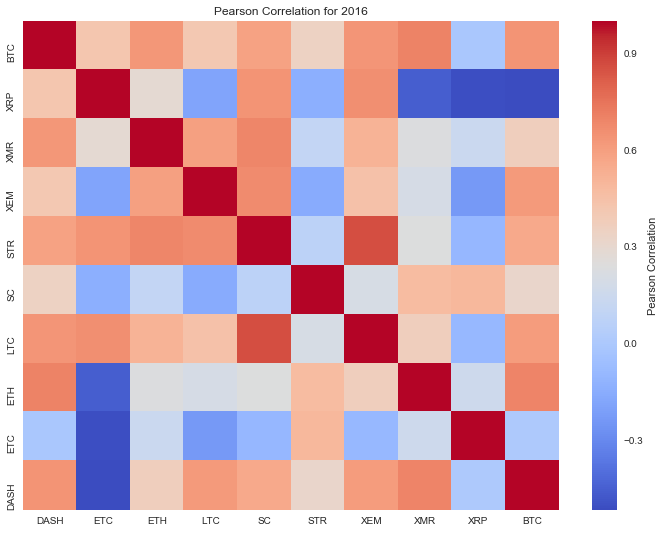

In [121]:
seaborn.set(rc={'figure.figsize':(12,9)})

ax = plt.axes()
ax.set_title('Pearson Correlation for 2016')
seaborn.heatmap(combined_df_2016.corr(method='pearson').as_matrix(), 
                xticklabels=combined_df_2016.columns, 
                yticklabels=list(reversed(combined_df_2016.columns)), 
                cmap='coolwarm', 
                cbar_kws={'label': 'Pearson Correlation'},
                ax=ax);

In [135]:
#correlation_heatmap(combined_df_2016.pct_change().corr(method='pearson'), "Cryptocurrency Correlations in 2016")


In [84]:
combined_df_2017 = combined_df[combined_df.index.year == 2017]
combined_df_2017.pct_change().corr(method='pearson')

,DASH,ETC,ETH,LTC,SC,STR,XEM,XMR,XRP,BTC
DASH,1.000000,0.387555,0.506911,0.340153,0.291424,0.183038,0.325968,0.498418,0.091146,0.307095
ETC,0.387555,1.000000,0.601437,0.482062,0.298406,0.210387,0.321852,0.447398,0.114780,0.416562
ETH,0.506911,0.601437,1.000000,0.437609,0.373078,0.259399,0.399200,0.554632,0.212350,0.410771
LTC,0.340153,0.482062,0.437609,1.000000,0.339144,0.307589,0.379088,0.437204,0.323905,0.420645
SC,0.291424,0.298406,0.373078,0.339144,1.000000,0.402966,0.331350,0.378644,0.243872,0.325318
STR,0.183038,0.210387,0.259399,0.307589,0.402966,1.000000,0.339502,0.327488,0.509828,0.230957
XEM,0.325968,0.321852,0.399200,0.379088,0.331350,0.339502,1.000000,0.336076,0.268168,0.329431
XMR,0.498418,0.447398,0.554632,0.437204,0.378644,0.327488,0.336076,1.000000,0.226636,0.409183
XRP,0.091146,0.114780,0.212350,0.323905,0.243872,0.509828,0.268168,0.226636,1.000000,0.131469
BTC,0.307095,0.416562,0.410771,0.420645,0.325318,0.230957,0.329431,0.409183,0.131469,1.000000


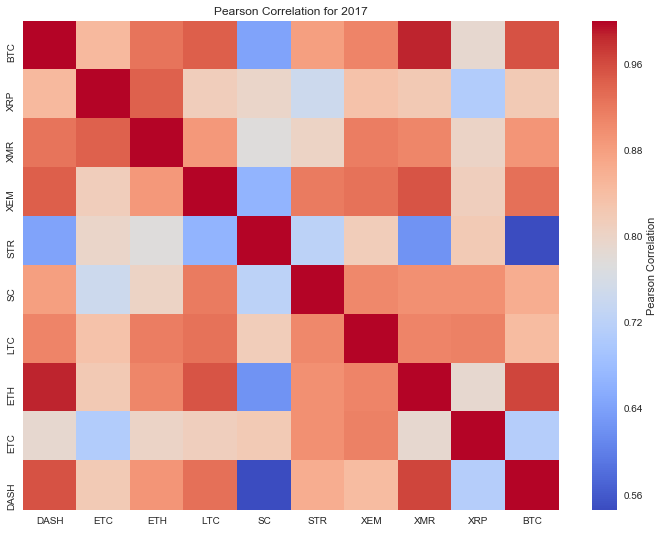

In [122]:
seaborn.set(rc={'figure.figsize':(12,9)})

ax = plt.axes()
ax.set_title('Pearson Correlation for 2017')
seaborn.heatmap(combined_df_2017.corr(method='pearson').as_matrix(), 
                xticklabels=combined_df_2017.columns, 
                yticklabels=list(reversed(combined_df_2017.columns)), 
                cmap='coolwarm', 
                cbar_kws={'label': 'Pearson Correlation'},
                ax=ax);

In [136]:
#correlation_heatmap(combined_df_2017.pct_change(), "Cryptocurrency Correlations in 2017")


# Conclusion

In this notebook we performed the following routines and analysis
    1. Create helper functions to pull cryptocurrency prices from quandl and Poloniex
    2. Create helper functions to construct dataframes of USD Priced Cryptocurrencies
    3. Perform basic visualizations with plotly
    4. Compute correlation matrices with pandas 
    5. Compute Pearson coefficients for cryptocurrency pairs in pandas
    6. Plot Pearson correlation matrices with Plotly

Further Analysis and Exercises
----------------------------


1. Compute changes in volume of cryptocurrency trades 
2. Compute volatility among different currencies and plot how volatility changes through time
3. Analyse and study volatility regimes between different currency pairs or baskets
4. Compare moving averages and see how the moving averages change between pairs
5. Visualize these findings with plotly, seaborn, or bokeh



Credits
-------

https://blog.patricktriest.com/analyzing-cryptocurrencies-python/